In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import os
from pyshred import DataManager, SHRED, SHREDEngine, MLP, PI_SHRED, LSTM
from matplotlib.tri import Triangulation
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import DataLoader, random_split

## Setting the CUDA stuff

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Helper functions (to be put in utilz later on)

In [4]:
def load_circle_comsol_data(file_path, verbose = False):
    #REMARK... the csv file is saved in a manner without headers. Thus the first row is data, but is currently interpreted as headers.
    #So we are neglecting the first row of data here as for now. This should be fixed in the future.
    
    data = pd.read_csv(file_path)
    names = data.columns 
    X = data[names[0]].values
    Y = data[names[1]].values
    p = data[names[-1]].values
    index = X**2 + Y**2 <0.8**2
    X_inner = X[index]
    Y_inner = Y[index]
    data_inner = data[names[2:]].values[index,:].T
    
    tri = Triangulation(X_inner, Y_inner)
    
    if verbose:
        print(f"Data loaded from {file_path}")
        print(f"Number of spatial points inside the circle: {data_inner.shape[1]}")
        print(f"Number of time steps: {data_inner.shape[0]}")
        
    return data_inner, tri

def generate_circle_sensors_from_tri(nr_sensors, tri,circle_fraction = [-np.pi,np.pi],scale = 0.6):
    #Which part of the unit circle to sample from
    samples = np.linspace(circle_fraction[0],circle_fraction[1]-2*np.pi/nr_sensors, nr_sensors)
    X_sample = np.cos(samples)*scale
    Y_sample = np.sin(samples)*scale
    sensor_indices = []
    for i in range(len(samples)):
        idx_temp = np.argmin((X_sample[i]-tri.x)**2+(Y_sample[i]-tri.y)**2)
        sensor_indices.append(idx_temp)
    sensors = [(sensor_indices[i],) for i in range(len(sensor_indices))]
    return sensors


def trajectory_gen(data_list,lags,sensors):
    if not isinstance(data_list, list):
        raise TypeError('data type of data_list must be a list')
    t_dim = data_list[0].shape[0]
    x_dim = data_list[0].shape[1]
    trajectories = np.zeros((t_dim-lags,len(sensors),lags))
    full_states = np.zeros((t_dim-lags,x_dim))
    
    for n, data_temp in enumerate(data_list):       
        for i in range(t_dim-lags):
            for j in range(len(sensors)):
                trajectories[i,j,:] = data_temp[i:i+lags,sensors[j]]
            full_states[i,:] = data_temp[i+lags,:]

        if n < 1:
            X = trajectories.copy()
            y = full_states.copy()
        
        else:
            X = np.vstack((X,trajectories))
            y = np.vstack((y,full_states))
    return X, y

def get_sensor_data(data_list, sensor_locations):
    if not isinstance(data_list, list):
        raise TypeError('data type of data_list must be a list')
    
    t_dim = data_list[0].shape[0]
    sensor_measurements_temp = np.zeros((t_dim, len(sensor_locations)))
    for n, data_temp in enumerate(data_list):
        for j, sensor in enumerate(sensor_locations):
            sensor_measurements_temp[:, j] = data_temp[:, sensor]
        if n < 1:
           sensor_measurements = sensor_measurements_temp.copy()
        else:
           sensor_measurements = np.vstack((sensor_measurements, sensor_measurements_temp))
    return sensor_measurements


def data_prepare(data_list, lags, sensors, scaler_X = None,scaler_y = None):
    if  scaler_X is None:
        sensor_measurements = get_sensor_data(data_list, sensors)
        scaler_X = MinMaxScaler()
      
        scaler_X = scaler_X.fit(sensor_measurements)
        # print(sensor_measurements.shape)
        
        X, y = trajectory_gen(data_list, lags, sensors)
              
        scaler_y = {
            "y_min": np.min(y),
            "y_max": np.max(y)
        }
        
        # scaler_y = scaler_y.fit(y.T)
        y = (y - scaler_y["y_min"])/(scaler_y["y_max"] - scaler_y["y_min"])
        for i in range(X.shape[0]):
            X[i, :, :] = scaler_X.transform(X[i, :, :].T).T
            
        return X, y, scaler_X, scaler_y
    else:
        X, y = trajectory_gen(data_list, lags, sensors)
        y = (y - scaler_y["y_min"])/(scaler_y["y_max"] - scaler_y["y_min"])
        for i in range(X.shape[0]):
            X[i, :, :] = scaler_X.transform(X[i, :, :].T).T
        return X, y
    
    
class SHREDdata(torch.utils.data.Dataset):
    """
    PyTorch Dataset for time series sensor data and corresponding full-state measurements.

    Parameters
    ----------
    DATA: dictionary containg X and y
    
    X : torch.Tensor
        Input sensor sequences of shape (batch_size, lags, num_sensors).
    Y : torch.Tensor
        Target full-state measurements of shape (batch_size, state_dim).

    Attributes
    ----------
    X : torch.Tensor
        Sensor measurement sequences.
    Y : torch.Tensor
        Full-state target measurements.
    len : int
        Number of samples in the dataset.
    """

    def __init__(self, DATA):
        """
        Initialize the TimeSeriesDataset.

        Parameters
        ----------
        X : torch.Tensor
            Input sensor sequences of shape (batch_size, lags, num_sensors).
        Y : torch.Tensor
            Target full-state measurements of shape (batch_size, state_dim).
        """
        self.X = DATA['X']
        self.Y = DATA['y']
        self.len = self.X.shape[0]
        
    def __getitem__(self, index):
        """
        Get a single sample from the dataset.

        Parameters
        ----------
        index : int
            Index of the sample to retrieve.

        Returns
        -------
        tuple
            (sensor_sequence, target_state) pair.
        """
        return self.X[index], self.Y[index]

    def __len__(self):
        """
        Get the number of samples in the dataset.

        Returns
        -------
        int
            Number of samples.
        """
        return self.len
     
    def split_data(self, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seed=42,sequential_split=False):
        if sequential_split:
            total_len = len(self)
            train_end = int(total_len * train_ratio)
            val_end = train_end + int(total_len * val_ratio)

            train_data = {
                'X': self.X[:train_end],
                'y': self.Y[:train_end]
            }
            val_data = {
                'X': self.X[train_end:val_end],
                'y': self.Y[train_end:val_end]
            }
            test_data = {
                'X': self.X[val_end:],
                'y': self.Y[val_end:]
            }
            train_dataset = SHREDdata(train_data)
            val_dataset = SHREDdata(val_data)
            test_dataset = SHREDdata(test_data)

        else:
            generator = torch.Generator().manual_seed(seed)
            train, val, test = torch.utils.data.random_split(self, [train_ratio, val_ratio, test_ratio], generator=generator)

            train_data = {
                'X':self.X[train.indices],
                'y':self.Y[train.indices]
            }
            val_data = {
                'X':self.X[val.indices],
                'y':self.Y[val.indices]
            }
            test_data = {
                'X':self.X[test.indices],
                'y':self.Y[test.indices]
            }
            train_dataset = SHREDdata(train_data)
            val_dataset = SHREDdata(val_data)
            test_dataset = SHREDdata(test_data)

        return train_dataset,val_dataset,test_dataset
    
    def move_to_device(self, device, model_dtype = torch.float32):
        self.X = torch.tensor(self.X, device=device, dtype=model_dtype)
        self.Y = torch.tensor(self.Y, device=device, dtype=model_dtype)
        return self
    
def SVD_pod_reconstruction(U_r,y, sensors, r):

    C= np.zeros_like(U_r.T)
    for i,sens in enumerate(sensors[:r]):
        C[i,sens] = 1
        
    A = C.dot(U_r)
    A_U, A_S, A_V = np.linalg.svd(A, full_matrices=False)
    P_inv_A = np.dot(A_V.T,np.dot(np.diag(1/A_S), A_U.T))
    
    s = y[sensors[:r]]
    a = P_inv_A.dot(s)

    recon = np.zeros_like(y)
    for i in range(r):
        recon += a[i]*U_r[:,i]
    
    return recon

In [9]:
#Loading the desired dataset:
import os
folder_path = "planewave_with_angles/"
counter = 0
data_loaded = []
print("Loading training data...")
for file in os.listdir(folder_path):
    if file.endswith(".csv") and file.startswith("train"):
        if counter == 0: 
            path = os.path.join(folder_path, file)
            data_temp, tri = load_circle_comsol_data(path, verbose=True)
            data_loaded.append(data_temp)
            counter += 1
            
        else:
            path = os.path.join(folder_path, file)
            data_temp, _ = load_circle_comsol_data(path, verbose=True)
            data_loaded.append(data_temp)
            # counter += len(data_temp)
            # print(counter)
            # if counter >= 5:
                # break
test_data = []
print("Loading test data...")
for file in os.listdir(folder_path):
    if file.endswith(".csv") and file.startswith("test"):
        path = os.path.join(folder_path, file)
        test_data_temp, _ = load_circle_comsol_data(path, verbose=True)
        test_data.append(test_data_temp)

Loading training data...
Data loaded from planewave_with_angles/train_plane_A1002_F1000.csv
Number of spatial points inside the circle: 2301
Number of time steps: 501
Data loaded from planewave_with_angles/train_plane_A1000_F1000.csv
Number of spatial points inside the circle: 2301
Number of time steps: 501
Data loaded from planewave_with_angles/train_plane_A1001_F1000.csv
Number of spatial points inside the circle: 2301
Number of time steps: 501
Data loaded from planewave_with_angles/train_plane_A1004_F1000.csv
Number of spatial points inside the circle: 2301
Number of time steps: 501
Data loaded from planewave_with_angles/train_plane_A1003_F1000.csv
Number of spatial points inside the circle: 2301
Number of time steps: 501
Data loaded from planewave_with_angles/train_plane_A1007_F1000.csv
Number of spatial points inside the circle: 2301
Number of time steps: 501
Data loaded from planewave_with_angles/train_plane_A1009_F1000.csv
Number of spatial points inside the circle: 2301
Number 

In [71]:
path_temp = "Data/pml_2d_circle_alternating.csv"
# data_temp,tri = load_circle_comsol_data(path_temp, verbose=True)
# data_test = []
# data_test.append(data_temp)
# data_test.append(data_temp)
# data_test = [data_temp]  # Making it a list to be compatible

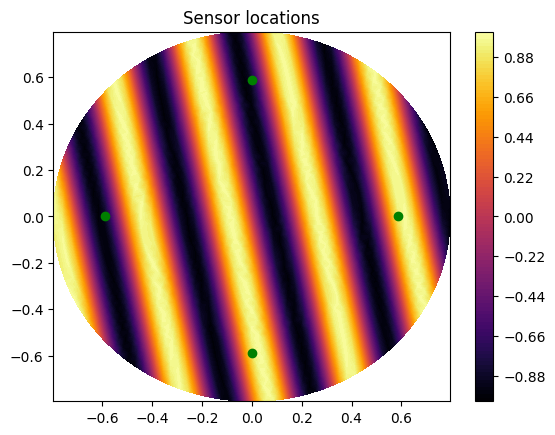

In [10]:
nr_sensors = 4
sensors = generate_circle_sensors_from_tri(nr_sensors, tri)

#Visualization of the sensors
fig,ax = plt.subplots()
plt.title("Sensor locations")
cfg1 = ax.tricontourf(tri, data_loaded[0][-1,:], levels=100,cmap = "inferno")
for i in sensors:
    ax.plot(tri.x[i],tri.y[i],color = "green", marker = "o")
fig.colorbar(cfg1, ax=ax)

In [13]:
lags = 15
# X, y, scaler = data_prepare(data_loaded, lags, [s[0] for s in sensors])
# data_dict = {
#     'X':X,
#     'y':y,
#     'scaler':scaler
# }
X_train, y_train, scaler_X, scaler_y = data_prepare(data_loaded, lags, [s[0] for s in sensors])
train_data_dict = {
    'X':X_train,
    'y':y_train,
    'scaler':scaler_X,
    'scaler_y':scaler_y
    
}

X_test, y_test = data_prepare(test_data, lags, [s[0] for s in sensors], scaler_X=scaler_X, scaler_y=scaler_y)
test_data_dict = {
    'X':X_test,
    'y':y_test,
    'scaler':scaler_X,
    'scaler_y':scaler_y
}

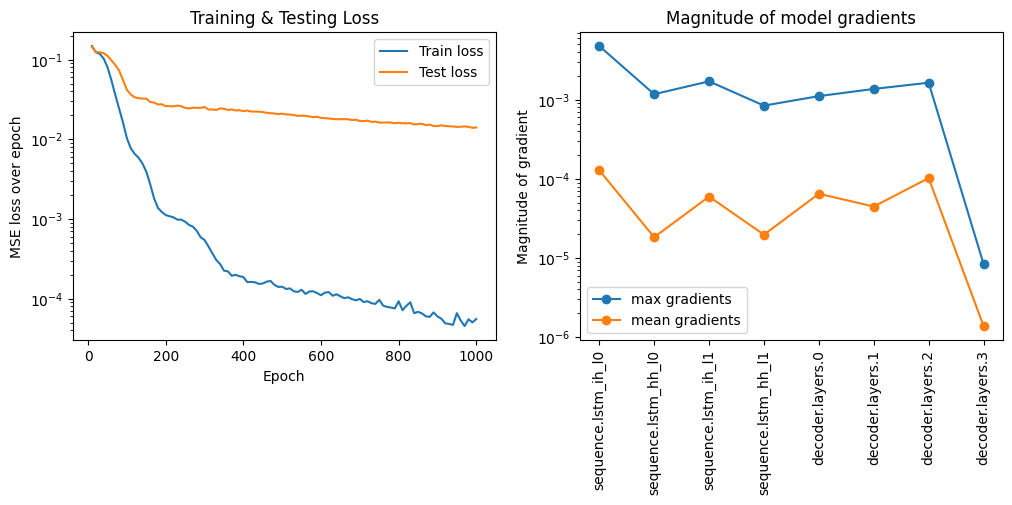

weee training done wewe


In [14]:
model_dtype = torch.float32

train_data = SHREDdata(train_data_dict)

test_dataset = SHREDdata(test_data_dict)
train_dataset, val_dataset, _ = train_data.split_data(train_ratio = 1.0, val_ratio=0.0, test_ratio=0.0, seed=42, sequential_split=False)

train_dataset.move_to_device(device, model_dtype=model_dtype)
# val_dataset.move_to_device(device, model_dtype=model_dtype)
test_dataset.move_to_device(device, model_dtype=model_dtype)


#Custom achitectures for the SHRED model
sequence_model = LSTM(
    hidden_size=32,
    num_layers=2
)
decoder_model = MLP(
    hidden_sizes=[64,128,22],
    dropout=0.0
)
shred = PI_SHRED(sequence_model=sequence_model,
    decoder_model=decoder_model)


val_errors = shred.fit(
    train_dataset=train_dataset,
    val_dataset=test_dataset,
    num_epochs=1000,
    batch_size= 128,
    verbose = False,
    plot = True,
    plot_modulo= 10,
    lr = 0.0005,
    patience = 50000,
    model_dtype = model_dtype
)


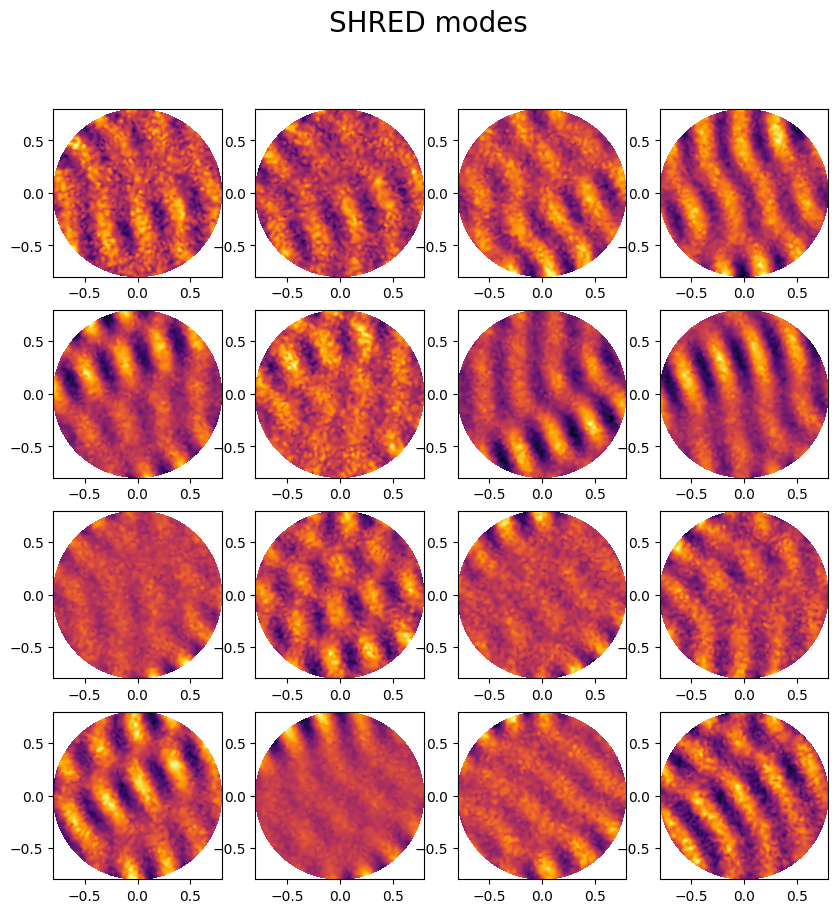

In [15]:
linear_layers = [m for m in shred.modules() if isinstance(m, torch.nn.Linear)]
# conv_layers = [m for m in shred.modules() if isinstance(m, torch.nn.Conv1d)]
last_layer = linear_layers[-1].weight.detach().cpu().numpy()

max_val_layer = np.max(last_layer)
min_val_layer = np.min(last_layer)
layer_levels = np.linspace(min_val_layer*1.1,max_val_layer*1.1, 300)
# error_levels = np.linspace(0,max_error*1.1, 300)
# print(test[:,0].shape)
nr_frames_x = 4
nr_frames_y = 4
counter = nr_frames_x*nr_frames_y*0
fig,ax = plt.subplots(nr_frames_y,nr_frames_x,figsize=(10,10))
for i in range(nr_frames_y):
    for j in range(nr_frames_x):
        cfg_temp = ax[i,j].tricontourf(tri, last_layer[:,counter], levels=100,cmap = "inferno")
        # fig.colorbar(cfg_temp, ax= ax[i,j]
        # ax[i,j].tricontourf(tri, last_layer[:,counter], levels=100,cmap = "inferno")
        counter += 1
plt.suptitle("SHRED modes",fontsize =20)
plt.show()

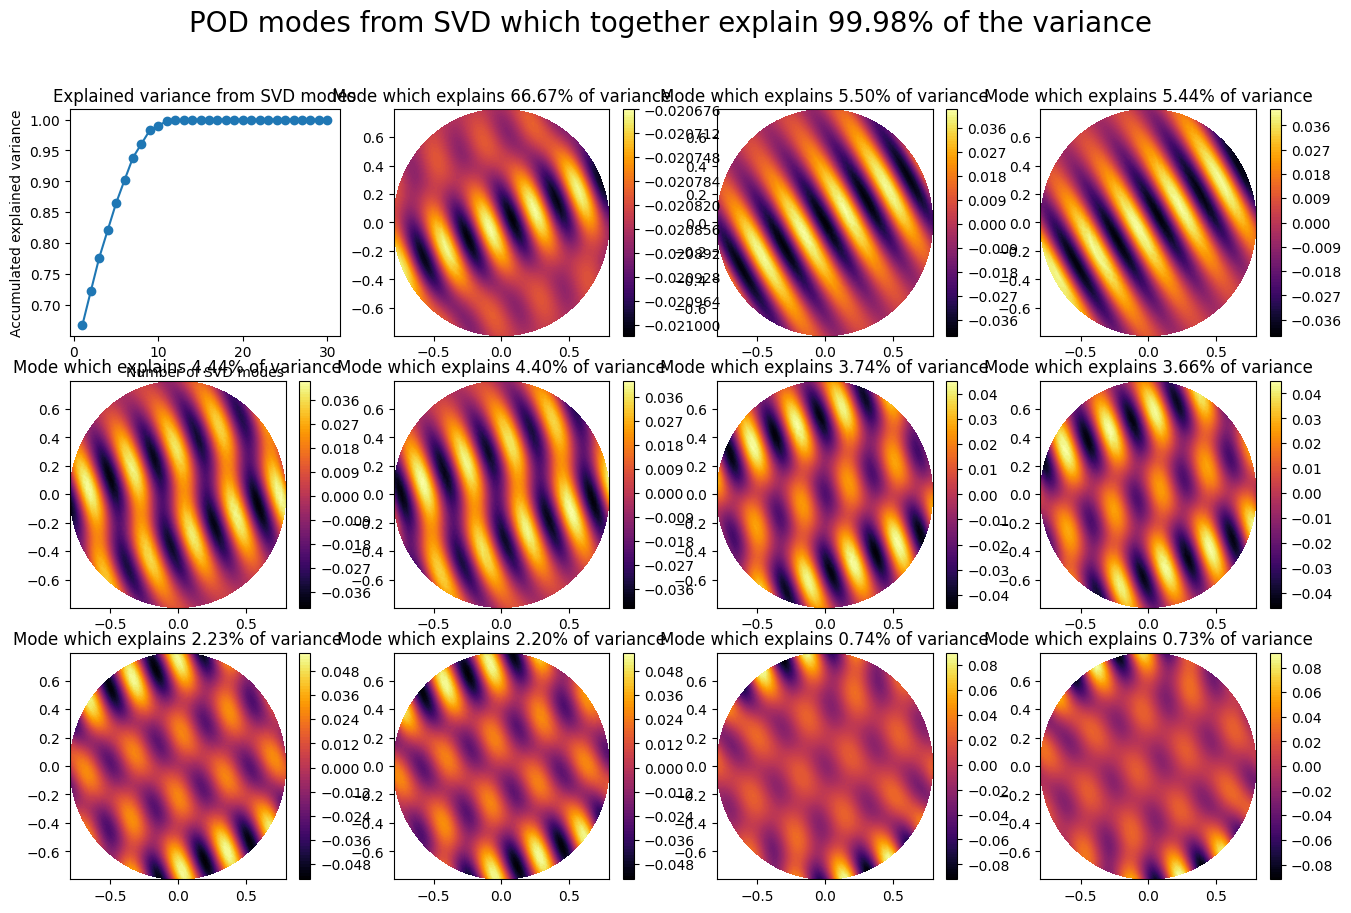

In [113]:
y_train = train_dataset.Y.cpu().numpy()
U,S,V = np.linalg.svd(y_train.T, full_matrices=False)
explained_variance = S**2 / np.sum(S**2)
explained_variance_cumsum = np.cumsum(explained_variance)
# S_accum = np.cumsum(S)
# S_accum = S_accum / S_accum[-1]
r = nr_sensors
U_r = U[:,0:r]

nr_frames_x = 4
nr_frames_y = 3
counter = nr_frames_x*nr_frames_y*0

fig,ax = plt.subplots(nr_frames_y,nr_frames_x,figsize=(16,10))
plt.suptitle(f"POD modes from SVD which together explain {100*explained_variance_cumsum[nr_frames_x*nr_frames_y]:.2f}% of the variance", fontsize=20)
for i in range(nr_frames_y):
    for j in range(nr_frames_x):
        if i==0 and j == 0:
            ax[i,j].plot(np.arange(1,len(explained_variance_cumsum[0:30])+1),explained_variance_cumsum[0:30],"o-")
            ax[i,j].set_title("Explained variance from SVD modes")
            ax[i,j].set_xlabel("Number of SVD modes")
            ax[i,j].set_ylabel("Accumulated explained variance")
        else:
            cfg_temp = ax[i,j].tricontourf(tri, U[:, counter], levels=100,cmap = "inferno")
            fig.colorbar(cfg_temp, ax = ax[i,j])
            ax[i,j].set_title(f"Mode which explains {explained_variance[counter]*100:.2f}% of variance")
            counter += 1
plt.show()


# Reconstruction with SVD pods without optimal sensor location



In [114]:
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=1)
# y_all = val_dataset.Y.cpu().numpy()
#plot with sensors locations

test_index = 0
svd_pred_list = []
shred_pred_list = []
true_sol_list = []
error_svd_list = []
error_shred_list = []

for i, (X_test,y_test) in enumerate(test_loader):
    y_test = y_test.cpu().numpy()
    shred_pred = shred.forward(X_test).detach().cpu().numpy()
    SVD_pred = SVD_pod_reconstruction(U_r, y_test[0,:], sensors, r=r)

    true_sol_list.append(y_test[0,:])

    svd_pred_list.append(SVD_pred)
    shred_pred_list.append(shred_pred)

    abs_error_svd = y_test[0,:] - SVD_pred
    abs_error_shred = y_test[0,:] - shred_pred[0,:]
    
    error_svd_list.append(abs_error_svd)
    error_shred_list.append(abs_error_shred)
    # if i == test_index:
    #     fig,ax = plt.subplots(2,3,figsize=(14,8))
    #     ax[0,0].tricontourf(tri, y_test[0,:], levels=100,cmap = "inferno")
    #     ax[0,0].set_title("Original")
    #     ax[0,1].tricontourf(tri, SVD_pred, levels=100,cmap = "inferno")
    #     ax[0,1].set_title("Reconstruction with SVD PODs")
    #     ax[0,2].tricontourf(tri, shred_pred[0,:], levels=100,cmap = "inferno")
    #     ax[0,2].set_title("Reconstruction with SHRED")
    #     error_svd = ax[1,1].tricontourf(tri, abs_error_svd, levels=100,cmap = "inferno")
    #     ax[1,1].set_title("Absolute error SVD POD")
    #     error_shred = ax[1,2].tricontourf(tri, abs_error_shred, levels=100,cmap = "inferno")
    #     ax[1,2].set_title("Absolute error SHRED")
    #     fig.colorbar(error_svd, ax=ax[1,1])
    #     fig.colorbar(error_shred, ax=ax[1,2])
    #     for i in sensors:
    #         if i == sensors[0]:
    #             ax[0,0].plot(tri.x[i],tri.y[i],color = "forestgreen",marker = "o",label = 'sensors')
    #             ax[0,1].plot(tri.x[i],tri.y[i],color = "forestgreen",marker = "o",label = 'sensors')
    #             ax[0,2].plot(tri.x[i],tri.y[i],color = "forestgreen",marker = "o",label = 'sensors')
    #             ax[1,1].plot(tri.x[i],tri.y[i],color = "forestgreen",marker = "o",label = 'sensors')
    #             ax[1,2].plot(tri.x[i],tri.y[i],color = "forestgreen",marker = "o",label = 'sensors')
    #         else:
    #             ax[0,0].plot(tri.x[i],tri.y[i],color = "forestgreen",marker = "o")
    #             ax[0,1].plot(tri.x[i],tri.y[i],color = "forestgreen",marker = "o")
    #             ax[0,2].plot(tri.x[i],tri.y[i],color = "forestgreen",marker = "o")
    #             ax[1,1].plot(tri.x[i],tri.y[i],color = "forestgreen",marker = "o")
    #             ax[1,2].plot(tri.x[i],tri.y[i],color = "forestgreen",marker = "o")

    #     plt.show()
    #     break

Gathering all the images needed for a gif here.

starting loop 0
starting loop 1
starting loop 2
starting loop 3
starting loop 4
starting loop 5
starting loop 6
starting loop 7
starting loop 8
starting loop 9
starting loop 10
starting loop 11
starting loop 12
starting loop 13
starting loop 14
starting loop 15
starting loop 16
starting loop 17
starting loop 18
starting loop 19
starting loop 20


IndexError: list index out of range

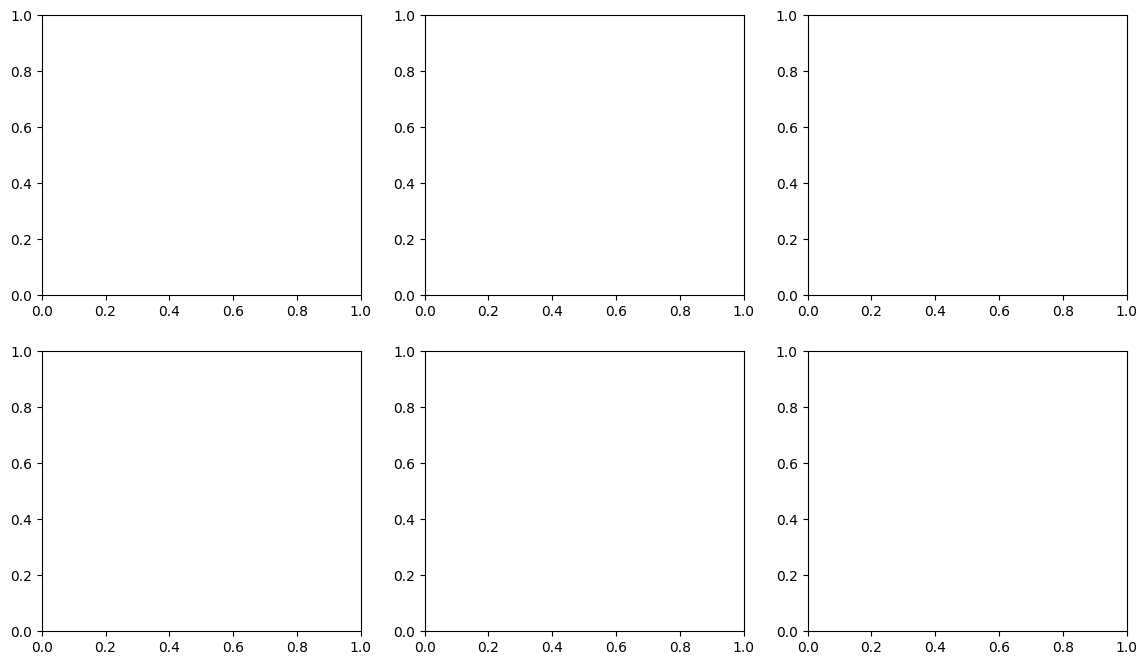

In [115]:
from io import BytesIO
from PIL import Image
nr_images = len(shred_pred_list)

true_max = np.max(true_sol_list)*1.1
true_min = np.min(true_sol_list)*1.1
pred_levels = np.linspace(true_min, true_max,100)

error_svd_hist = np.zeros(len(error_svd_list))
error_shred_hist = np.zeros(len(svd_pred_list))
for i in range(len(error_svd_hist)):
    error_svd_hist[i] = np.max(error_svd_list[i])
    error_shred_hist[i] = np.max(error_shred_list[i])

svd_error_max = np.max(error_svd_list)
svd_error_min = np.min(error_svd_list)
svd_error_levels = np.linspace(svd_error_min,svd_error_max, 100)

shred_error_max = np.max(error_shred_list)
shred_error_min = np.min(error_shred_list)
shred_error_levels = np.linspace(shred_error_min, shred_error_max,100)

images = []
for i in range(nr_images):
    print(f"starting loop {i}")
    if i == 40:
        break
    i = i*25

    fig,ax = plt.subplots(2,3,figsize=(14,8))
    cb_true = ax[0,0].tricontourf(tri, true_sol_list[i], levels=pred_levels,cmap = "inferno")
    fig.colorbar(cb_true, ax=ax[0,0])
    ax[0,0].set_title("True solution")
    cb_svd = ax[0,1].tricontourf(tri, svd_pred_list[i], levels=pred_levels,cmap = "inferno")
    fig.colorbar(cb_svd, ax=ax[0,1])
    ax[0,1].set_title("Reconstruction with SVD PODs")
    cb_shred = ax[0,2].tricontourf(tri, shred_pred_list[i][0,:], levels=pred_levels,cmap = "inferno")
    fig.colorbar(cb_shred, ax=ax[0,2])
    ax[0,2].set_title("Reconstruction with SHRED")
    error_svd = ax[1,1].tricontourf(tri, error_svd_list[i], levels=svd_error_levels,cmap = "inferno")
    ax[1,1].set_title("Absolute error SVD POD")
    error_shred = ax[1,2].tricontourf(tri, error_shred_list[i], levels=shred_error_levels,cmap = "inferno")
    ax[1,2].set_title("Absolute error SHRED")
    fig.colorbar(error_svd, ax=ax[1,1])
    fig.colorbar(error_shred, ax=ax[1,2])
    for i in sensors:
        if i == sensors[0]:
            ax[0,0].plot(tri.x[i],tri.y[i],color = "forestgreen",marker = "o",label = 'sensors')
            ax[0,1].plot(tri.x[i],tri.y[i],color = "forestgreen",marker = "o",label = 'sensors')
            ax[0,2].plot(tri.x[i],tri.y[i],color = "forestgreen",marker = "o",label = 'sensors')
            ax[1,1].plot(tri.x[i],tri.y[i],color = "forestgreen",marker = "o",label = 'sensors')
            ax[1,2].plot(tri.x[i],tri.y[i],color = "forestgreen",marker = "o",label = 'sensors')
        else:
            ax[0,0].plot(tri.x[i],tri.y[i],color = "forestgreen",marker = "o")
            ax[0,1].plot(tri.x[i],tri.y[i],color = "forestgreen",marker = "o")
            ax[0,2].plot(tri.x[i],tri.y[i],color = "forestgreen",marker = "o")
            ax[1,1].plot(tri.x[i],tri.y[i],color = "forestgreen",marker = "o")
            ax[1,2].plot(tri.x[i],tri.y[i],color = "forestgreen",marker = "o")
    ax[0,0].legend(loc = "upper left")

    max_error = np.amax([error_svd_hist,error_shred_hist])
    N_bins = 20
    bin_w = max_error / N_bins
    bin_edges = np.arange(0,N_bins) * bin_w
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    error_svd_hist_counts, _ = np.histogram(error_svd_hist, bins=bin_edges)
    error_shred_hist_counts, _ = np.histogram(error_shred_hist, bins=bin_edges)
    ax[1,0].set_title("max abs-error distribution over all predictions")
    ax[1,0].bar(bin_centers, error_svd_hist_counts, width=bin_w,alpha = 0.7, edgecolor="k",label = "svd-errors")
    ax[1,0].bar(bin_centers, error_shred_hist_counts, width=bin_w, alpha=0.7, edgecolor="k",label = "shred-errors")
    ax[1,0].legend()
    ax[1,0].set_ylabel("count")
    ax[1,0].set_xlabel("max abs error")

    buf = BytesIO()
    plt.savefig(buf, format = 'png')
    buf.seek(0)
    images.append(Image.open(buf))
    plt.close(fig)
    plt.show()
    # if i == 30:
        # break

In [116]:
images[0].save("Shred_SVD_viz/mix_test2_shred_svd_m6_s5.gif", save_all = True, append_images = images[1:],duration = 500, loop= 0)

Text(0.5, 0, 'max abs error')

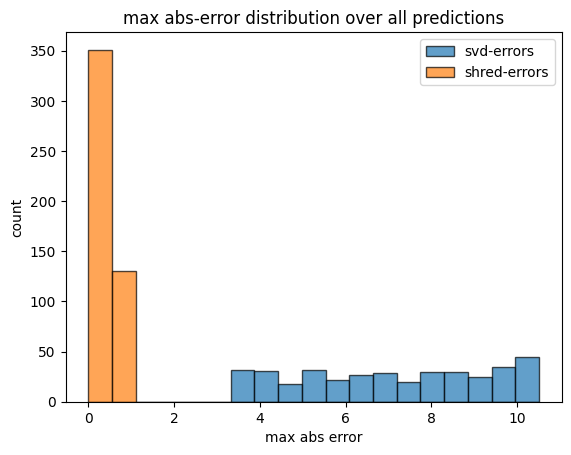

In [12]:
fig,ax = plt.subplots()
max_error = np.amax([error_svd_hist,error_shred_hist])
N_bins = 20
bin_w = max_error / N_bins
bin_edges = np.arange(0,N_bins) * bin_w
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

error_svd_hist_counts, _ = np.histogram(error_svd_hist, bins=bin_edges)
error_shred_hist_counts, _ = np.histogram(error_shred_hist, bins=bin_edges)
ax.set_title(f"max abs-error distribution over all predictions")
ax.bar(bin_centers, error_svd_hist_counts, width=bin_w,alpha = 0.7, edgecolor="k",label = "svd-errors")
ax.bar(bin_centers, error_shred_hist_counts, width=bin_w, alpha=0.7, edgecolor="k",label = "shred-errors")
ax.legend()
ax.set_ylabel("count")
ax.set_xlabel("max abs error")

In [39]:
for i in sensors:
    print(i)

(379,)
(344,)
(1301,)
(2224,)
(1384,)


# Visualization of the data for the first slide

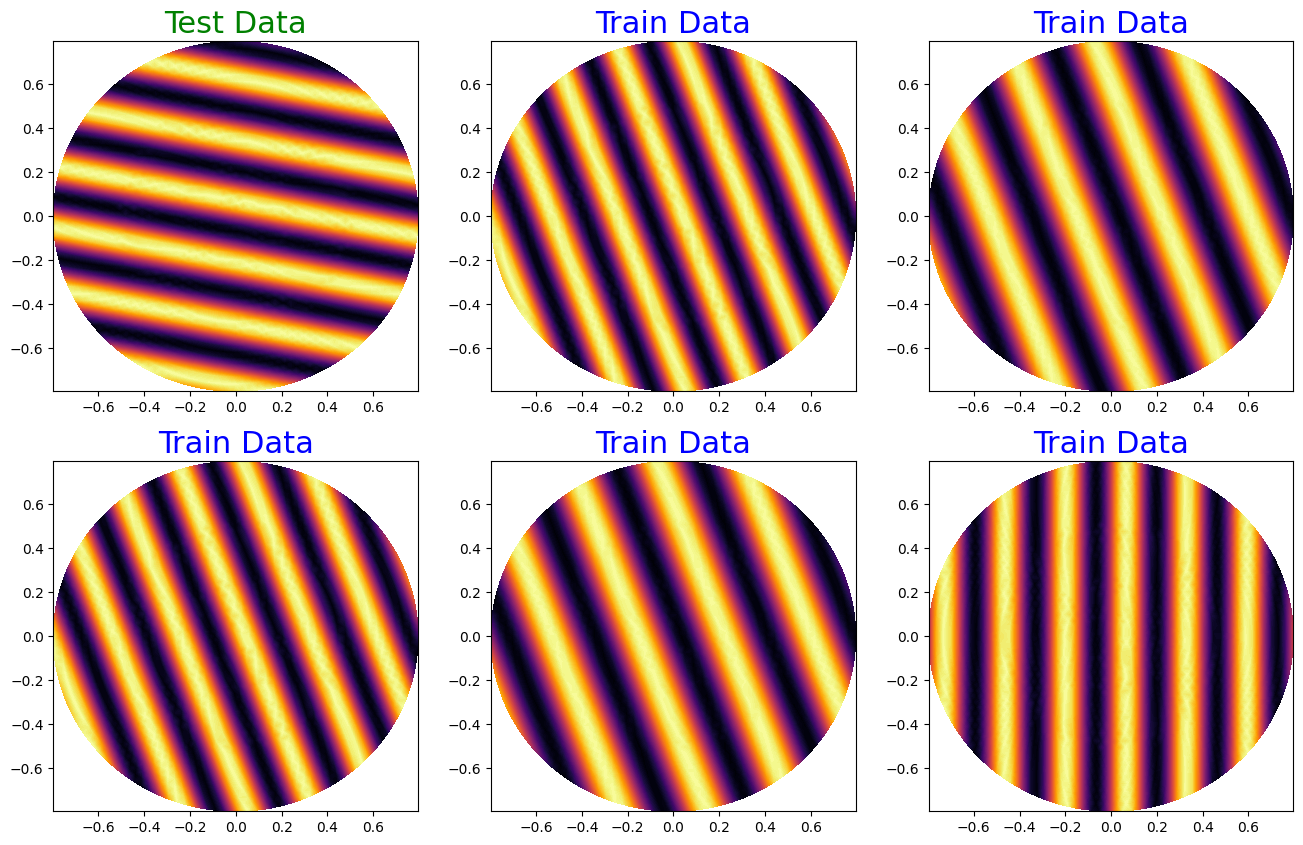

In [13]:
test_dataset.move_to_device(device, model_dtype=model_dtype)
fig,ax = plt.subplots(2,3,figsize=(16,10))
for i in range(2):
    for j in range(3):
        if i==0 and j==0:
            ax[i,j].set_title("Test Data", color = "green", fontsize = 22)
            ax[i,j].tricontourf(tri, test_dataset.Y[0,:].detach().cpu().numpy(), levels=100,cmap = "inferno")
        else:
            ax[i,j].set_title(f"Train Data", color = "blue", fontsize = 22)
            ax[i,j].tricontourf(tri, data_loaded[i+j][0,:], levels=100,cmap = "inferno")

In [ ]:
fig,ax = plt.subplots(2,3,figsize=(14,8))
        ax[0,0].tricontourf(tri, y_test[0,:].cpu().numpy(), levels=100,cmap = "inferno")
        ax[0,0].set_title("Original")
        ax[0,1].tricontourf(tri, SVD_pred[0,:], levels=100,cmap = "inferno")
        ax[0,1].set_title("Reconstruction with SVD PODs")
        ax[0,2].tricontourf(tri, shred_pred[0,:].detach().cpu().numpy(), levels=100,cmap = "inferno")
        ax[0,2].set_title("Reconstruction with SHRED")
        error_svd = ax[1,1].tricontourf(tri, abs_error_svd, levels=100,cmap = "inferno")
        ax[1,1].set_title("Absolute error SVD POD")
        error_shred = ax[1,2].tricontourf(tri, abs_error_shred, levels=100,cmap = "inferno")
        ax[1,2].set_title("Absolute error SHRED")
        fig.colorbar(error_svd, ax=ax[1,1])
        fig.colorbar(error_shred, ax=ax[1,2])
        for i in sensors:
            if i == sensors[0]:
                ax[0,0].plot(tri.x[i],tri.y[i],color = "green",marker = "o",label = 'sensors')
                ax[0,1].plot(tri.x[i],tri.y[i],color = "green",marker = "o",label = 'sensors')
                ax[0,2].plot(tri.x[i],tri.y[i],color = "green",marker = "o",label = 'sensors')
            else:
                ax[0,0].plot(tri.x[i],tri.y[i],color = "green",marker = "o")
                ax[0,1].plot(tri.x[i],tri.y[i],color = "green",marker = "o")
                ax[0,2].plot(tri.x[i],tri.y[i],color = "green",marker = "o")
        plt.show()